In [10]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Final

import evoml_client as ec
from evoml_client.trial_conf_models import BudgetMode

import evoml_client as ec
from dotenv import load_dotenv
 

In [11]:
def initialise_client(base_url: str):
    load_dotenv()
 
    username = os.getenv("USER_NAME")
    password = os.getenv("PASSWORD")

    ec.init(username=username, password=password, base_url=base_url)

In [21]:
BASE_URL = "http://192.168.58.242/"

# initialise client using credentials
initialise_client(BASE_URL)

In [16]:
# Load datasets
data = pd.read_csv("../data/cs-training.csv", index_col=0)
data.columns = data.columns.str.replace('-', '_')
target_column = "SeriousDlqin2yrs"

data_holdout = pd.read_csv("../data/cs-test.csv", index_col=0)
data_holdout.columns = data_holdout.columns.str.replace('-', '_')
data_holdout = data_holdout.drop(columns=[target_column])

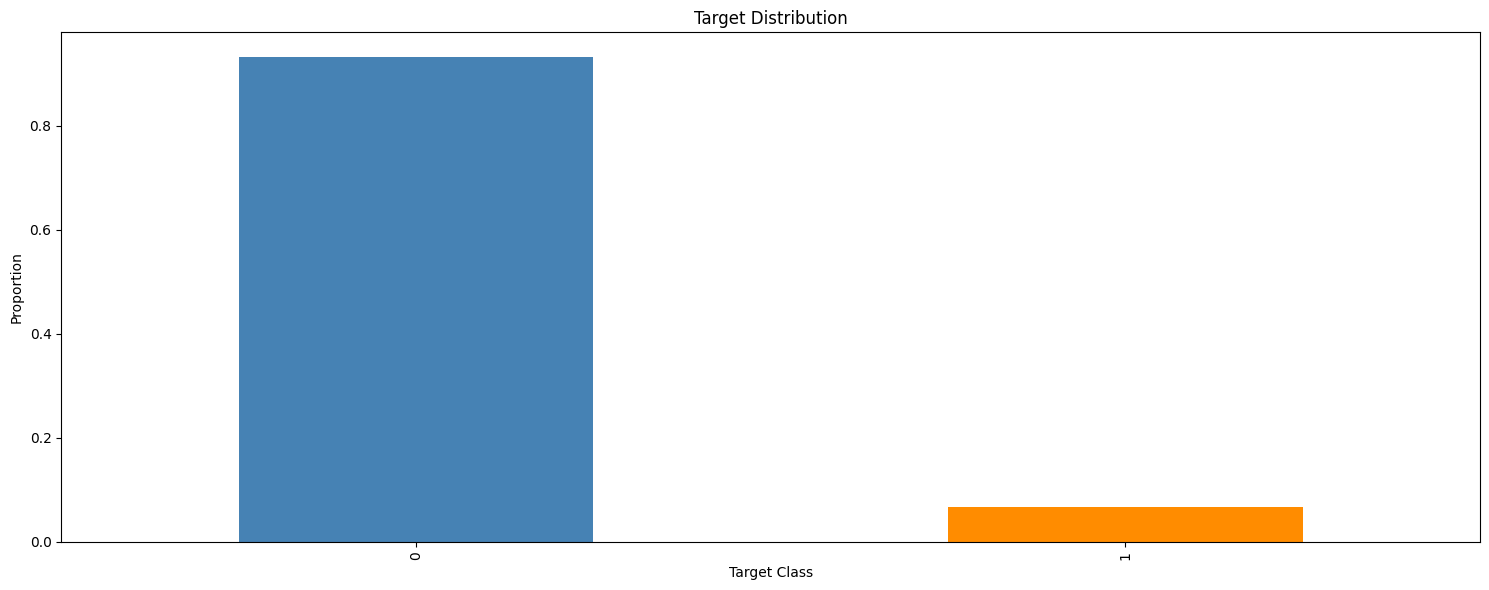

In [17]:
class_percentages = data[target_column].value_counts(normalize=True)
plt.figure(figsize=(15, 6))
class_percentages.plot(kind="bar", color=["steelblue", "darkorange"])
plt.title("Target Distribution")
plt.xlabel("Target Class")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

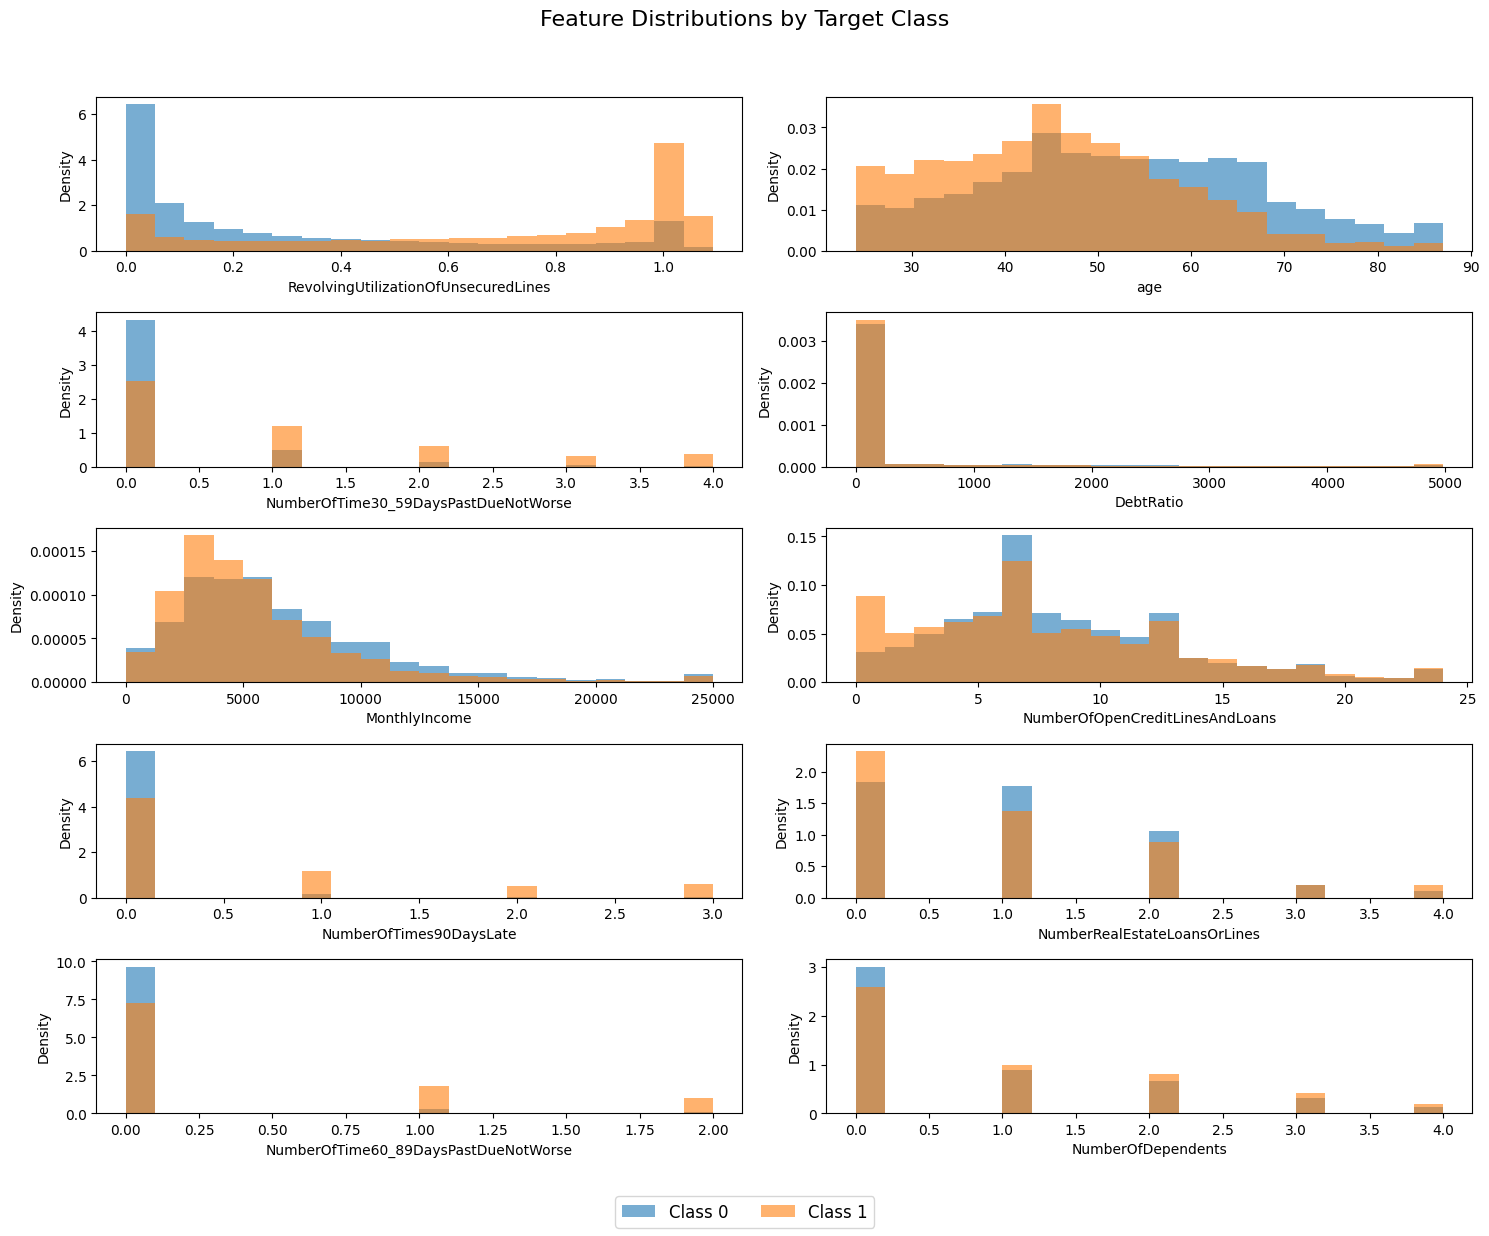

In [19]:
# Identify numeric columns (excluding the target)
numeric_cols = [
    col for col in data.columns
    if pd.api.types.is_numeric_dtype(data[col]) and col != target_column
]

# Calculate the number of rows and columns for the subplots grid
n_cols = 2
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Create subplots with a dynamic figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2.5 * n_rows))
fig.suptitle("Feature Distributions by Target Class", fontsize=16)
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Initialize variables for legend handles and labels
handles, labels = None, None

for i, col in enumerate(numeric_cols):
    # Filter data for each target class and drop missing values
    data_class0 = data[data[target_column] == 0][col].dropna()
    data_class1 = data[data[target_column] == 1][col].dropna()

    # Combine the data to compute shared percentile limits for clipping
    all_data = pd.concat([data_class0, data_class1])
    lower_limit, upper_limit = np.percentile(all_data, [1, 99])

    # Clip the data to mitigate outlier impact
    data_class0_clipped = data_class0.clip(lower=lower_limit, upper=upper_limit)
    data_class1_clipped = data_class1.clip(lower=lower_limit, upper=upper_limit)

    # Create shared bins based on the combined, clipped data
    shared_bins = np.histogram_bin_edges(
        pd.concat([data_class0_clipped, data_class1_clipped]), bins=20
    )

    # Plot the histograms for both classes on the current axis
    axes[i].hist(
        data_class0_clipped, bins=shared_bins, alpha=0.6, density=True, label="Class 0"
    )
    axes[i].hist(
        data_class1_clipped, bins=shared_bins, alpha=0.6, density=True, label="Class 1"
    )

    # Label the current axis
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

    # Capture legend information from the first subplot only
    if handles is None or labels is None:
        handles, labels = axes[i].get_legend_handles_labels()

# Remove any empty subplots if the grid contains extra axes
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

# Add a legend to the figure
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=12)

# Adjust layout to fit the legend and titles
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [23]:



dataset = ec.Dataset.from_pandas(data, name="Give Me Some Credit")
dataset.put()
dataset.wait()

print(f"Dataset URL: {BASE_URL}/platform/datasets/view/{dataset.dataset_id}")

Dataset URL: http://192.168.58.242//platform/datasets/view/67c5b982508e1a685594a8c2


In [24]:
config = ec.TrialConfig.with_default(
    task=ec.MlTask.classification,
    budget_mode=BudgetMode.fast,
    loss_funcs=["ROC AUC"],
    dataset_id=dataset.dataset_id,
)

# Trying disabling hyperparameter tuning for faster trial execution
# config.enableBudgetTuning = False

trial, _ = ec.Trial.from_dataset_id(
    dataset.dataset_id,
    target_col=target_column,
    trial_name="Give Me Some Credit",
    config=config,
)

trial.run(timeout=900)

 98%|█████████▊| 3196/3262 [00:00<00:00, 36004.64kb/s]


Couldnt match any status: ,status ispending


True

In [ ]:
metrics = trial.get_metrics_dataframe()
selected_metrics = metrics.loc[:, pd.IndexSlice["classification-roc", ["validation", "test"]]]
print(selected_metrics.sort_values(by=("classification-roc", "validation"), ascending=False).iloc[:5])

In [ ]:
best_model = trial.get_best()
best_model.build_model()

In [ ]:
# Predict default probabilities on the holdout data
predictions = np.array(best_model.predict_proba(data=data_holdout))

# Extract the probabilities for the default outcome (1)
default_probabilities = predictions[:, 1]

# Conditioned data
conditioned_data = data_holdout["NumberOfTimes90DaysLate"] == 0
probabilities_conditioned_true = default_probabilities[conditioned_data]
probabilities_conditioned_false = default_probabilities[~conditioned_data]

# Plot the histograms
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(probabilities_conditioned_true, bins=20, alpha=0.75, color="steelblue")
plt.title("Predicted Default Probabilities (NumberOfTimes90DaysLate >= 0)")
plt.xlabel("Predicted Probability of Default (1)")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(probabilities_conditioned_false, bins=20, alpha=0.75, color="darkorange")
plt.title("Predicted Default Probabilities (NumberOfTimes90DaysLate < 0)")
plt.xlabel("Predicted Probability of Default (1)")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()